### Лабораторная работа №4
####  Исследование абсолютно-оптимальных рекуррентных алгоритмов

### вар. 5

Для оценки эффективности абсолютно-оптимальных алгоритмов рассмотрим задачу идентификации параметров линейного регрессионного объекта вида:
\begin{equation}y(i)=с_{0}+с_{1}u_{1}(i)+...+с_{4}u_{4}(i)+\eta(i)\end{equation}

Пусть шум измерений $\eta(i)$ имеет распределение Коши:
\begin{equation*}
f(\eta)=\frac{1}{\pi s}\frac{1}{(1+(\eta/s)^2)}
\end{equation*}

In [19]:
import math
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [101]:
# параметры объекта 
c0=3.5
c1=-0.3
c2=0.
c3=6.
c4=-2.2

In [21]:
# количество измерений
N=200

In [22]:
np.random.seed(1)

In [128]:
# параметр распределения Коши
s=1

In [169]:
Avg_U1=1
Var_U1=100
Avg_U2=1
Var_U2=100
Avg_U3=1
Var_U3=100
Avg_U4=1
Var_U4=100

In [170]:
Noise=st.cauchy.rvs(loc=0, scale=s, size=N)
U1=np.random.normal(Avg_U1,Var_U1,size=N)
U2=np.random.normal(Avg_U2,Var_U2,size=N)
U3=np.random.normal(Avg_U3,Var_U3,size=N)
U4=np.random.normal(Avg_U4,Var_U4,size=N)

In [171]:
# моделирование выхода объекта
y=c0+c1*U1+c2*U2+c3*U3+c4*U4+Noise

In [172]:
# моделирование входов объекта
def recalc_in_params(local_s):
    s = local_s
    Noise=st.cauchy.rvs(loc=0, scale=s, size=N)
    U1=np.random.normal(Avg_U1,Var_U1,size=N)
    U2=np.random.normal(Avg_U2,Var_U2,size=N)
    U3=np.random.normal(Avg_U3,Var_U3,size=N)
    U4=np.random.normal(Avg_U4,Var_U4,size=N)
    y=c0+c1*U1+c2*U2+c3*U3+c4*U4+Noise
    return U1, U2, U3, U4, y

In [173]:
U1, U2, U3, U4, y = recalc_in_params(10)

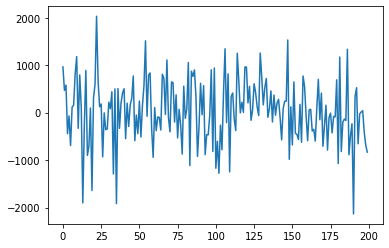

In [174]:
plt.plot(y)
plt.show()

#### Формирование алгоритма идентификации

В зависимости от того, насколько хорошо изучен «объект» идентификации, могут возникнуть следующие ситуации:

1. Объект изучен хорошо, правильно определена плотность распределения шума, т.е. принятая и реальная плотности распределения совпадают и на основе принятой функции распределения формируется оптимальная функция потерь.


2. Объект изучен плохо. При этом, как правило, считают, что плотность распределения шума соответствует нормальному закону распределения, хотя на самом деле(в данном случаем, см. описание объекта выше) шум имеет распределение Коши. Таким образом, опираясь на ложную гипотезу о нормальном распределении шума, в качестве функции потерь выбирается квадратичная функция.

Предлагается реализовать абсолютно-оптимальный рекуррентный алгоритм оценивания параметров объекта для каждой из ситуаций. Для   оценки   эффективности использования абсолютно-оптимальных  рекуррентных  алгоритмов  проводилось сравнение сглаженной ошибки оценки параметров объекта,определенных когда объект изучили хорошо и когда плохо, при  различных  значениях  параметра  распределения Коши — s.

#### В первом случае рекуррентный алгоритм принимает вид:
\begin{equation}\hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)\frac{2(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i))}{s^2+(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i))^2}\vec{z}(i) \\
Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{2s^2+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
Г(0)=\lambda I, \lambda=0.1\\
\hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

In [111]:
def get_first_method_result():
    I = np.eye(5)
    lyambda = 0.1
    gamma = lyambda*I

    c = np.zeros((N,5), dtype=np.double) 
    c[0, :] = np.array([c0, c1, c2, c3, c4])

    for i in range(1, N):
        z = np.asmatrix([1, U1[i], U2[i], U3[i], U4[i]]).transpose()
        zt = z.getT()
        gamma = gamma - (gamma*z*zt*gamma)/(2*np.power(s, 2)+zt*gamma*z)

        y_delta = y[i] - np.dot(c[i-1,:],z)[0,0]
        c[i] = c[i-1] + (gamma*2*y_delta/(np.power(s,2)+np.power(y_delta, 2))*z).getT()
    
    return c

print(get_first_method_result()[-1])

[ 3.48875163e+00 -2.96577957e-01  1.67919902e-03  5.99994840e+00
 -2.20080003e+00]


#### Во втором случае рекуррентный алгоритм принимает вид:
\begin{equation}\hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)\vec{z}(i)(y(i)-\hat{c}_{0}(i-1)u_{0}(i)-...-\hat{c}_{4}(i-1)u_{4}(i)) \\
Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{1+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
Г(0)=\lambda I , \lambda=0.1    \\
\hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

In [114]:
def get_second_method_result():
    I = np.eye(5)
    lyambda = 0.1
    gamma = lyambda*I

    cc = np.zeros((N,5), dtype=np.double) 
    cc[0, :] = np.array([c0, c1, c2, c3, c4])

    for i in range(1, N):
        z = np.asmatrix([1, U1[i], U2[i], U3[i], U4[i]]).transpose()
        zt = z.getT()
        gamma = gamma - (gamma*z*zt*gamma)/(1+zt*gamma*z)

        y_delta = y[i] - np.dot(cc[i-1,:],z)[0,0]
        cc[i] = cc[i-1] + (gamma*z*y_delta).getT()
    return cc

print(get_second_method_result()[-1])

[ 2.21334109e+00 -3.00341139e-01 -2.13863394e-03  5.99474692e+00
 -2.20114832e+00]


Сглаженная ошибка оценки вычисляется по формуле:
\begin{equation*}
err_{сгл}=\sqrt{\frac{\sum_{j=1}^{10}\sum_{k=0}^4(\hat{c}_{k}(i-j)-c_{k})^2}{10}} ; i=10,11,12...
\end{equation*}

In [108]:
np.power([1,2,3],2)

array([1, 4, 9])

0.1
3.4907	-0.2990	0.0006	6.0003	-2.2007
2.2133	-0.3003	-0.0043	5.9842	-2.2046


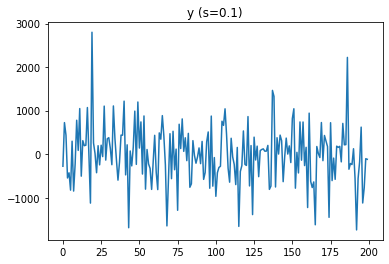

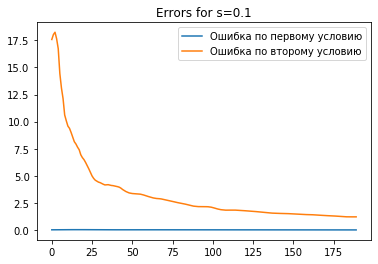

2
3.5651	-0.2778	0.0091	6.0065	-2.2124
-22.2332	-0.3068	-0.0855	5.6848	-2.2919


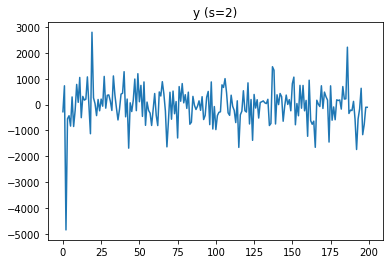

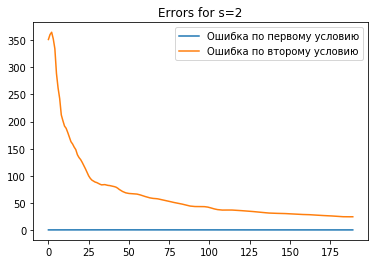

10
3.6187	-0.2970	-0.0137	6.0503	-2.2042
-125.1659	-0.3341	-0.4277	4.4241	-2.6593


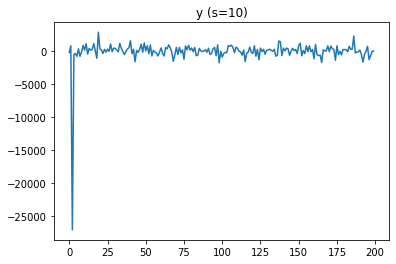

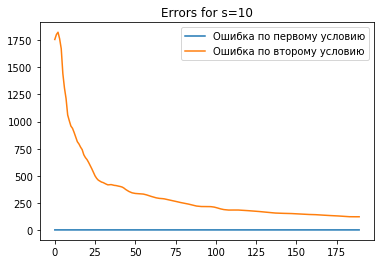

In [191]:
for s in (0.1, 2, 10):
    np.random.seed(1)
    U1, U2, U3, U4, y = recalc_in_params(s)
    
    plt.figure(0)
    plt.title(f"y (s={s})")
    plt.plot(y)
    
    c = get_first_method_result()
    cc = get_second_method_result()
    
    print(s)
    print("\t".join(["{:.4f}".format(x) for x in c[-1]]))
    print("\t".join(["{:.4f}".format(x) for x in cc[-1]]))
    
    err1 = np.zeros((N-10, 1), dtype=np.double)
    err2 = np.zeros_like(err1)

    errs1 = np.zeros((N-10, 1), dtype=np.double)
    errs2 = np.zeros_like(err1)


    c_real = np.array([c0,c1,c2,c3,c4], dtype=np.double)

    for idx, i in enumerate(range(10,N)):
        e1 = 0
        e2 = 0
        for j in range(1,10):
            e1 += np.sum(np.power(c[i-j, :] - c_real, 2))
            e2 += np.sum(np.power(cc[i-j, :] - c_real, 2))

        errs1[idx] = np.sqrt(e1/10)
        errs2[idx] = np.sqrt(e2/10)

    plt.figure(1)
    plt.title(f"Errors for s={s}")
    plt.plot(errs1, label="Ошибка по первому условию")
    plt.plot(errs2, label="Ошибка по второму условию")
    plt.legend()

    plt.show()